In [1]:
!pip install transformers
!pip install datasets
!pip install accelerate


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00


In [32]:
!pip install httpx
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.8 MB/s eta 0:00:00


In [111]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='transformers.generation.utils')


In [74]:
from transformers import CLIPProcessor, CLIPModel
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

In [112]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [113]:
img = Image.open("/content/_125840770_hi077252483.jpg")
inp = processor(images=img, return_tensors="pt")
out = model.generate(**inp)
description = processor.decode(out[0], skip_special_tokens=True)

print(description)


a large area of rainforest land in the amazon rainforest


In [49]:

import torch


In [41]:
import base64


def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [99]:
import requests
from groq import Groq

API_KEY = api_token
g = Groq(
		 api_key = API_KEY,
)

enc_im = encode_image("/content/_125840770_hi077252483.jpg")
prompt = "Identify 8 possible causes which led to this disaster in the picture, return them as a list with each answer in curly brackets, just return the causes, no other sentence"

completion = g.chat.completions.create(
    model="llama-3.2-11b-vision-preview",
    messages=[
        {
            "role": "user",
            "content": [
								{
									 "type": "text",
									 "text": "The image shows destruction of this area known as" + description
								},

                {
                    "type": "text",
                    "text": prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{enc_im}",
                    },
                }
            ]
        },
        {
            "role": "assistant",
            "content": ""
        }
    ],
    temperature=1,
    max_tokens=512,
    top_p=1,
    stream=False,
    stop=None,
)

msg = completion.choices[0].message.content
print(msg)

{Clear-cutting of land for agricultural use}
{Logging and deforestation for wood and non-wood products}
{Cattle grazing and livestock farming causing soil erosion}
{Sustainable agriculture practices are not being used}
{Fire spread from a controlled agricultural burn}
{Overgrazing caused by livestock farming}
{Soil nutrient depletion due to soil erosion}
{Failure of local population to maintain sustainable agriculture practices to provide sufficient food supply}


In [100]:
causes = [line.strip() for line in msg.split('\n') if line.strip()]


print(causes)


['{Clear-cutting of land for agricultural use}', '{Logging and deforestation for wood and non-wood products}', '{Cattle grazing and livestock farming causing soil erosion}', '{Sustainable agriculture practices are not being used}', '{Fire spread from a controlled agricultural burn}', '{Overgrazing caused by livestock farming}', '{Soil nutrient depletion due to soil erosion}', '{Failure of local population to maintain sustainable agriculture practices to provide sufficient food supply}']


In [101]:

image_inputs = clip_processor(images=img, return_tensors="pt")
text_inputs = clip_processor(text=causes, return_tensors="pt", padding=True)


In [102]:
with torch.no_grad():
    image_features = clip_model.get_image_features(**image_inputs)
    text_features = clip_model.get_text_features(**text_inputs)

In [103]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity_sc = (image_features @ text_features.T).squeeze(0)

Insight: {Logging and deforestation for wood and non-wood products}, Score: 0.27670764923095703
Insight: {Clear-cutting of land for agricultural use}, Score: 0.25762999057769775
Insight: {Cattle grazing and livestock farming causing soil erosion}, Score: 0.24377301335334778


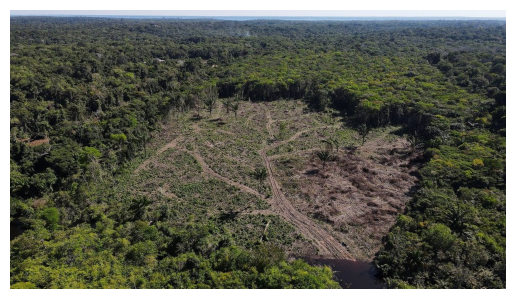

In [110]:
import matplotlib.pyplot as plt

srt_idx = similarity_sc.argsort(descending=True)

for idx in srt_idx[:3]:
    print(f"Insight: {causes[idx]}, Score: {similarity_sc[idx].item()}")

plt.imshow(img)
plt.axis('off')
plt.show()